In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distr

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from data_train_test_funcs import mnist_dataloaders, train

### Parameters

In [2]:
gpu = True
epochs = 20
batch_size = 100
num_workers = 4

### Dataset definition

In [3]:
train_loader, test_loader = mnist_dataloaders(batch_size=batch_size, num_workers=num_workers, pin_memory=gpu)

### Network definition

In [4]:
class Encoder(nn.Module):
    def __init__(self, l0, l1):
        super(Encoder, self).__init__()
         
        # Define layers
        self.fc0 = nn.Linear(28*28, l0)
        self.fc1_mu = nn.Linear(l0, l1)
        self.fc1_sigma = nn.Linear(l0, l1)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        # Compute
        h = F.relu(self.fc0(x))
        mu = self.fc1_mu(h)
        logvar = self.fc1_sigma(h)
        
        return mu, logvar 
        
class Decoder(nn.Module):
    def __init__(self, l0, l1):
        super(Decoder, self).__init__()
        
        # Define layers
        self.fc0 = nn.Linear(l0, l1)
        self.fc1 = nn.Linear(l1, 28*28)
        
    def forward(self, x):
        
        # Compute
        h = F.relu(self.fc0(x))
        out = torch.sigmoid(self.fc1(h))
        
        return out
        
class VAE(nn.Module):
    def __init__(self, l0, l1):
        super(VAE, self).__init__()
        self.encoder = Encoder(l0, l1)
        self.decoder = Decoder(l1, l0)
        
    def forward(self, x):
        # Generate deterministic mean and std
        z_mu, z_logvar = self.encoder(x)
        
        # Sample epsilon and make z stochastic
        eps = torch.randn_like(z_logvar)
        z_sigma = torch.exp(0.5 * z_logvar)
        z = z_mu + eps*z_sigma
        
        # Perform decoding, or sample from X
        y = self.decoder(z)
        
        return y, z_mu, z_logvar

### Loss definition

In [5]:
def ELBO(input, output, mu, logvar):
    reconstruction_error = F.binary_cross_entropy(output, input.view(-1, 784), reduction="sum")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_error + kld

### Training

In [6]:
model = VAE(400, 20)
optimizer = optim.Adam(model.parameters())

def train_step(batch):
    optimizer.zero_grad()
    
    # Forward
    input = batch[0].view(-1, 784)
    net_out, mu, logvar = model(input)
    
    # Loss and step
    loss = ELBO(input, net_out, mu, logvar)
    loss.backward()
    optimizer.step()
    
    return loss

train(train_step, model, train_loader, epochs=epochs, gpu=gpu)

Current loss 10420.326171875: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it] 

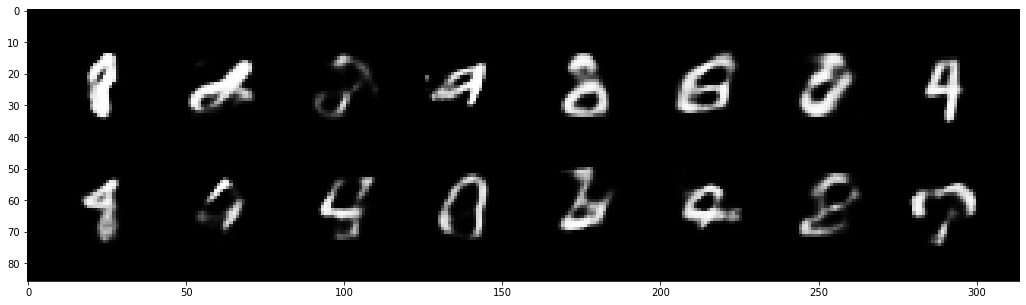

In [7]:
# Show samples
model = model.cpu()
sample = torch.randn(16, 20)
sample = model.decoder(sample).detach()
ims = make_grid(sample.view(-1, 1, 28, 28), nrow=8, padding=10)
ims = ims.numpy()

plt.figure(figsize=(20, 5))
plt.imshow(np.transpose(ims, (1, 2, 0)), interpolation="nearest")
plt.show()